In [1]:
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt
import numpy as np
import cotengra as ctg

from mera_hubbard import FH_Hamiltonian_NN_half_filling, solve_ground_state

c:\Users\LauraMismetti\IBM\hubbard_qcnn\.venv\Lib\site-packages\cotengra\hyperoptimizers\hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
num_sites = 2
t1 = 1.
t2 = 0.5 # trying without the NN terms first, as additional check
U = 2.

In [3]:
# FH HAMILTONIAN
ham, sparse_ham = FH_Hamiltonian_NN_half_filling(num_sites, t1, t2, U, pbc=0) # pbc=0: open BC, pbc=1: cyclic BC
ham.show()
en, _, _ = solve_ground_state(num_sites, ham, sparse_ham)

Reference ED at half-filling:


c:\Users\LauraMismetti\IBM\hubbard_qcnn\.venv\Lib\site-packages\quimb\experimental\operatorbuilder\operatorbuilder.py:1404: NumbaTypeSafetyWarning: unsafe cast from int64 to undefined. Precision may be lost.
  ci = bitmap[bi]


energy =  -1.2360679774997887
number of particles =  2.0


New Hamiltonian at half-filling:
chemical potential at half-filling =  -0.882
SparseOperatorBuilder(nsites=4, nterms=10, locality=2))
+ - . .  -1.0
- + . .  -1.0
. . + -  -1.0
. . - +  -1.0
n . n .  +2.0
sn. . .  -0.8820000000001231
. . sn.  -0.8820000000001231
. n . n  +2.0
. sn. .  -0.8820000000001231
. . . sn -0.8820000000001231
energy =  -1.2360679774997894
number of particles =  2.0


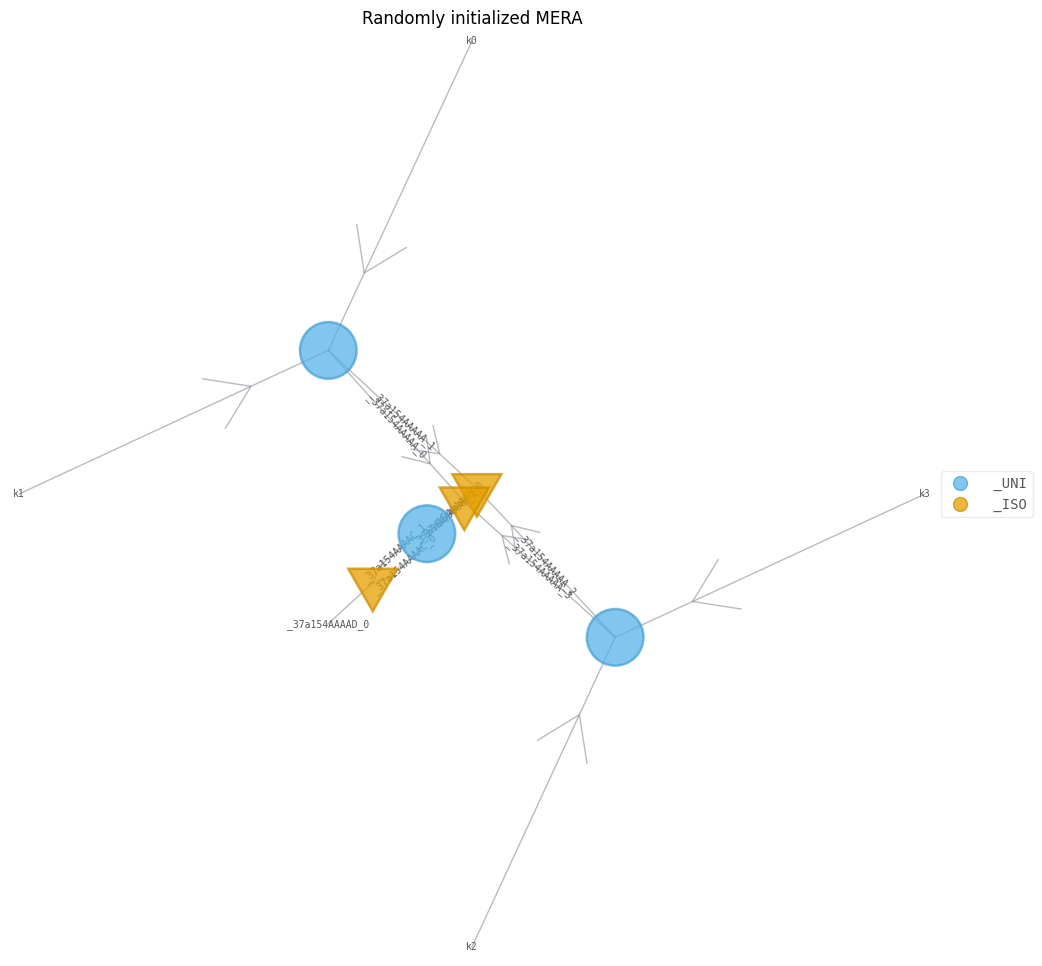

In [4]:
# try initialization MERA
n = num_sites*2
mera = qtn.MERA.rand(n, dangle=True)
# plot settings
from math import cos, sin, pi
fix = {
    f'k{i}': (sin(-2 * pi * i / n), cos(-2 * pi * i / n))
    for i in range(n)
}

draw_opts = dict(fix=fix, k=0.1, title='Randomly initialized MERA', figsize=(12,12))
node_shape = dict([('_UNI','o'), ('_ISO','v')])
mera.draw(color=['_UNI', '_ISO'], show_tags=False, show_inds='all', node_size=0.7, node_shape=node_shape, node_alpha=0.75, **draw_opts)

In [5]:
def norm_fn(mera):
    # there are a few methods to do the projection
    # exp works well for optimization
    return mera.isometrize(method='exp')

def expectation_sites(mera, local_terms, optimize='auto-qt'):
    """Compute the energy given the mera and the local terms of the hamiltonian
    """
    # if we pass directly the hamiltonian the optimizer complains...
    energy = 0.

    for key in local_terms:
        sites = []

        term = local_terms[key]
        # if it is the U term (so involving n)
        # if key[0][1] == key[1][1]:
        #     term = np.array([[U, 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]])
        
        for item in key:
            if item[0] == '↑':
                sites.append(item[1]-1)
            elif item[0] == '↓':
                sites.append(item[1]-1 + int(ham.nsites/2))

        # what gate should we apply?? (instead of 'term')
        mera_op = mera.gate(term, sites, propagate_tags=False)

        # print(sites)
        # print(term)
        # mera_op.draw(color=['_UNI', '_ISO'], show_inds=True, show_tags=False) # , **draw_opts)
        
        mera_ex = mera_op & mera.H # apply the h.c. of the mera to calculate the expectation value

        energy += mera_ex.contract(all, optimize=optimize) # calculate the expect. value
    
    return energy

In [14]:
# study MAX_BOND
n = num_sites * 2 
max_bond = 2
max_bond_vec = [max_bond]
energy_opt = []
en_mera = en + 1.
suff_max_bond = None

while not np.isclose(en_mera, en, atol=0.0001):

    print(f'\n*************** MAX_BOND = {max_bond} ***************\n')
    # Initialization MERA
    mera = qtn.MERA.rand(n, max_bond=max_bond) #, dangle=True) # the dangle option determines if the last isometry has an external edge not connected to anything else.. it affects the dimension of the tensor!!!
    mera.isometrize_()

    # build local terms to then compute the energy term by term (needed for the optimization of the MERA)
    local_terms = ham.build_local_terms()

    # To find a high quality contraction path for each term 
    opt = ctg.ReusableHyperOptimizer(
        progbar=True,
        reconf_opts={},
        max_repeats=16,
        # directory=  # set this for persistent cache
    )

    expectation_sites(mera, local_terms, optimize=opt)
    expectation_sites(mera, local_terms, optimize=opt)

    # REAL OPTIMIZATION
    # set-up the MERA optimizer object:
    tnopt = qtn.TNOptimizer(
        mera,
        loss_fn=expectation_sites, 
        norm_fn=norm_fn,
        loss_constants={'local_terms': local_terms},
        loss_kwargs={'optimize': opt},
        autodiff_backend='torch', device='cpu', jit_fn=True, 
    )

    # the first step involves compiling the computation, which might take some time and print some (ignorable) warnings:
    tnopt.optimize(1)

    tnopt.optimizer = 'l-bfgs-b'  # the default
    mera_opt_hubbard = tnopt.optimize(999)

    tnopt.optimizer = 'adam'  # useful for final iterations
    mera_opt_hubbard = tnopt.optimize(1000)    

    en_mera = expectation_sites(mera_opt_hubbard, local_terms, optimize=opt)
    energy_opt.append(en_mera)
 
    if np.isclose(en_mera, en, atol=0.0001) and suff_max_bond is None:
        suff_max_bond = max_bond
        print('\nsufficient max_bond =', suff_max_bond)

    max_bond += 2
    max_bond_vec.append(max_bond)



*************** MAX_BOND = 2 ***************



log2[SIZE]: 4.00 log10[FLOPs]: 2.62: 100%|██████████| 16/16 [00:00<00:00, 77.48it/s]
+1.079237389270 [best: +1.079237389270] : : 2it [00:01,  1.45it/s]                     
-1.236067974984 [best: -1.236067974984] :   4%|▎         | 37/999 [00:00<00:13, 71.34it/s]
-1.236067974883 [best: -1.236067977500] : : 1001it [00:18, 53.72it/s]                        


sufficient max_bond = 2


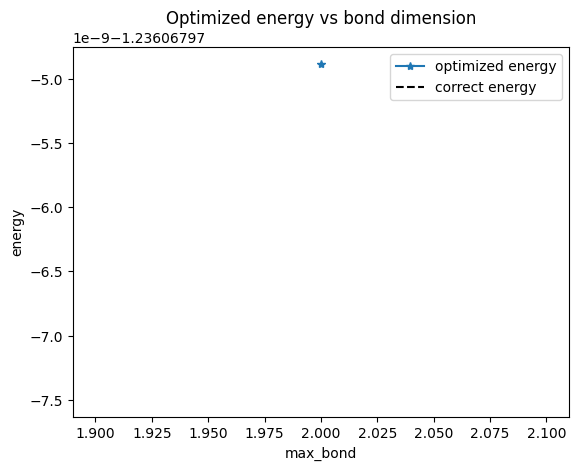

In [15]:
plt.figure()
plt.title('Optimized energy vs bond dimension')
plt.xlabel('max_bond')
plt.ylabel('energy')
plt.plot(max_bond_vec[0:len(energy_opt)], energy_opt, '-*', label='optimized energy')
plt.hlines(en, max_bond_vec[0], max_bond_vec[len(energy_opt)-1], linestyle='--', color='black', label='correct energy')
plt.legend()
plt.show()

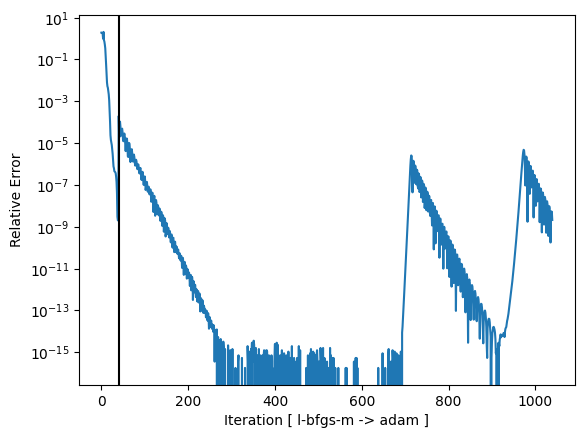

In [16]:
# plot the relative error during optimization
rel_err = (np.array(tnopt.losses) - en) / abs(en)

plt.plot(rel_err)
plt.xlabel('Iteration [ l-bfgs-m -> adam ]')
plt.ylabel('Relative Error')
plt.yscale('log')
plt.axvline(len(tnopt.losses) - 1000, color='black')
# plt.savefig('error_vs_it-hubbard.png')
plt.show()

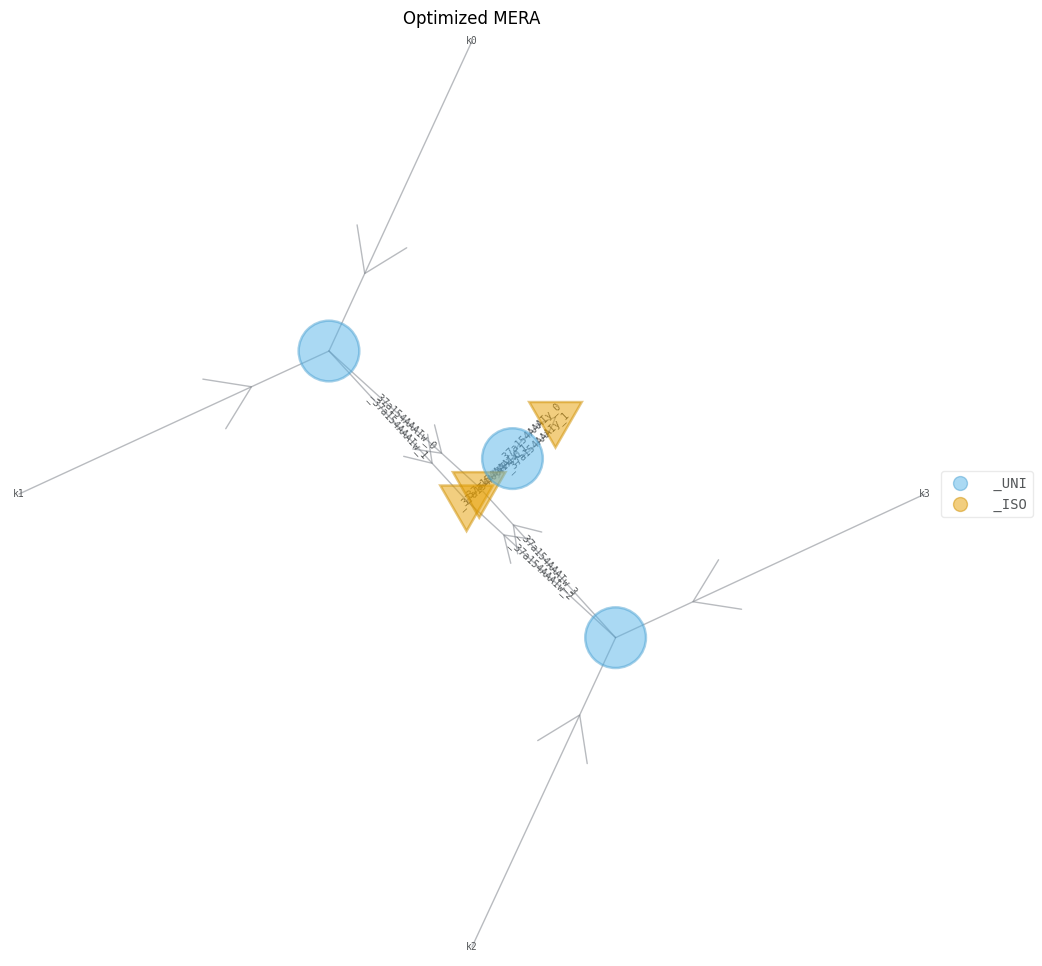

In [17]:
# plot the optimized MERA
# plot settings
from math import cos, sin, pi
fix = {
    f'k{i}': (sin(-2 * pi * i / n), cos(-2 * pi * i / n))
    for i in range(n)
}

draw_opts = dict(fix=fix, k=0.1, title='Optimized MERA', figsize=(12,12))
node_shape = dict([('_UNI','o'), ('_ISO','v')])
mera_opt_hubbard.draw(color=['_UNI', '_ISO'], show_tags=False, show_inds='all', node_size=0.75, node_shape=node_shape, node_alpha=0.5, **draw_opts)


By looking at the last letter and number of the inds it is possible to identify a certain edge (all the characters before are just a random base, equal for all the edges)
through those indices the tensors representing unitaries and isometries are uniquely identified (they have a precise position)

!!! counter-clockwise spiral !!! + refer to the figure 

In [18]:
# # save the dictionary as .json file, easier to upload in qiskit..
# import json

# mera_tensors = dict()
# for tn in mera_opt_hubbard.tensors:
#     # print(tn.left_inds) # indices of the edges that 'enter' the node
#     # print(tn.get_params())
#     mera_tensors[tn.left_inds[0]+tn.left_inds[1]] = tn.get_params().tolist()

# # Writing to sample.json
# with open(f"optMERA_1x{num_sites}_U={U}_t2={t2}.json", "w") as outfile:
#     # Serializing json
#     json_object = json.dumps(mera_tensors)
#     outfile.write(json_object)

In [19]:
# # Opening JSON file
# with open(f'opt_MERA_U={U}_t2={t2}.json', 'r') as openfile:
#     # Reading from json file
#     mera_json = json.load(openfile)

# # recovering the tensors
# for item in mera_json:
#     print(np.asarray(mera_json[item]))

In [20]:
# # save the optimized MERA with the quimb function
# qu.save_to_disk(mera_opt_hubbard, f'opt_MERA_U={U}_t2={t2}')

# # to load it 
# new_mera = qu.load_from_disk(f'opt_MERA_U={U}_t2={t2}')

In [21]:
# # select the tensors layer by layer
# for n_layer in np.arange(0,np.log2(mera_opt_hubbard.nsites)):
#     mera_layer = mera_opt_hubbard.select([f'_LAYER{int(n_layer)}'], 'all')
#     node_shape = dict([('_UNI','o'), ('_ISO','v')])
#     mera_layer.draw(color=['_UNI', '_ISO'], show_inds='all', show_tags=False, node_shape=node_shape)
#     # we select only the unitaries
#     mera_l_uni = mera_layer.select(['_UNI'], 'all')
#     print(mera_l_uni)
#     print(mera_l_uni.get_params())
#     # then only the isometries
#     mera_l_iso = mera_layer.select(['_ISO'], 'all')
#     print(mera_l_iso)
#     print(mera_l_iso.get_params())